In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.special import inv_boxcox

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Machine learning/REGRESSION/Datasets/cars_details.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [3]:
df.shape

(301, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df.describe(include = 'number')

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [6]:
df.describe(include = 'object')

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,301,301,301,301
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,195,261


In [7]:
#print the unique car names
df['Car_Name'].nunique()

98

In [8]:
#since Car_Name constains 98 uniq categories. it is very high compared to our total data samples. So we are dropping it
df.drop('Car_Name',axis = 1, inplace = True)

In [9]:
#So we gonna create a column called Age from Year based on the max Year value
df.insert( 0, 'Age', df['Year'].max()+1-df['Year'] )
df.drop('Year', axis = 1, inplace = True)
df.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,5,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,6,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,8,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,5,4.60,6.87,42450,Diesel,Dealer,Manual,0


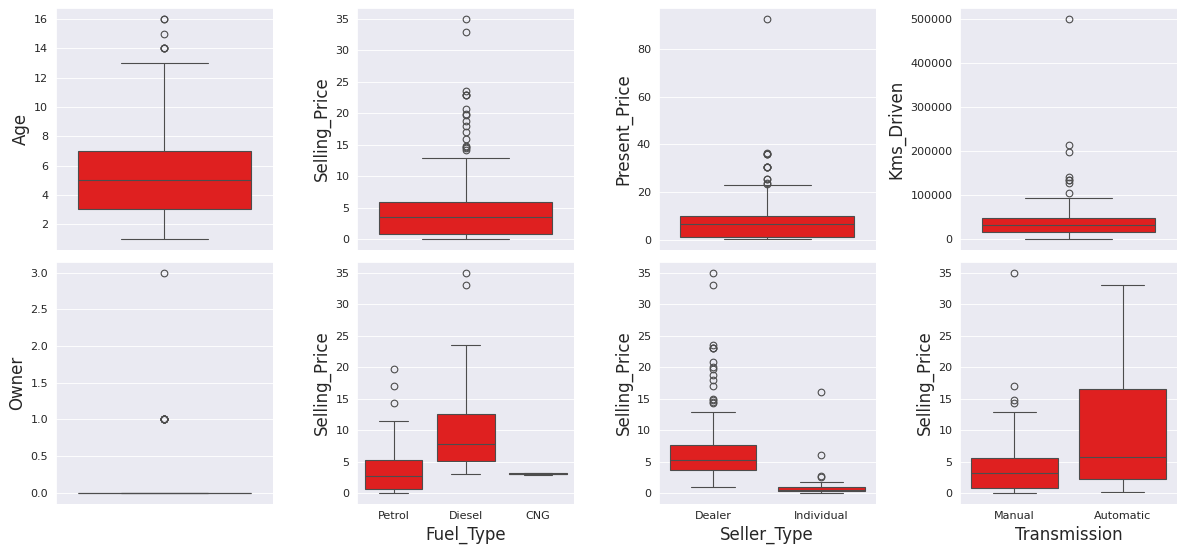

In [10]:
#outlier detection
sns.set_style('darkgrid')
colors = ['#ff0000', '#0000ff', '#0000ff']
CustomPalette = sns.set_palette(sns.color_palette(colors))

OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values,
                              df.select_dtypes(include='object').columns.values])

fig, ax = plt.subplots(2, 4, figsize=(15,7),dpi=80)

for i,col in enumerate(OrderedCols):
    x = i//4
    y = i%4
    if i<5:
        sns.boxplot(data=df, y=col, ax=ax[x,y])
        ax[x,y].yaxis.label.set_size(15)
    else:
        sns.boxplot(data=df, x=col, y='Selling_Price', ax=ax[x,y])
        ax[x,y].xaxis.label.set_size(15)
        ax[x,y].yaxis.label.set_size(15)

plt.tight_layout()
plt.show()

In [11]:
#Getting all the indices of the outliers
outliers_indexes = []
target = 'Selling_Price'

for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())
        print(outliers_indexes)

for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())

outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

[66, 69, 97]
[66, 69, 97, 64, 86]
[66, 69, 97, 64, 86]
[66, 69, 97, 64, 86, 50, 51, 52, 59, 62, 63, 64, 66, 69, 79, 80, 82, 86, 93, 96, 97]
[66, 69, 97, 64, 86, 50, 51, 52, 59, 62, 63, 64, 66, 69, 79, 80, 82, 86, 93, 96, 97, 27, 53, 54, 85]
[66, 69, 97, 64, 86, 50, 51, 52, 59, 62, 63, 64, 66, 69, 79, 80, 82, 86, 93, 96, 97, 27, 53, 54, 85, 69, 80, 86, 97]
[66, 69, 97, 64, 86, 50, 51, 52, 59, 62, 63, 64, 66, 69, 79, 80, 82, 86, 93, 96, 97, 27, 53, 54, 85, 69, 80, 86, 97]
38 outliers were identified, whose indices are:

[27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 205, 79, 80, 82, 84, 85, 86, 92, 93, 96, 97, 106, 241]


[86, 196]


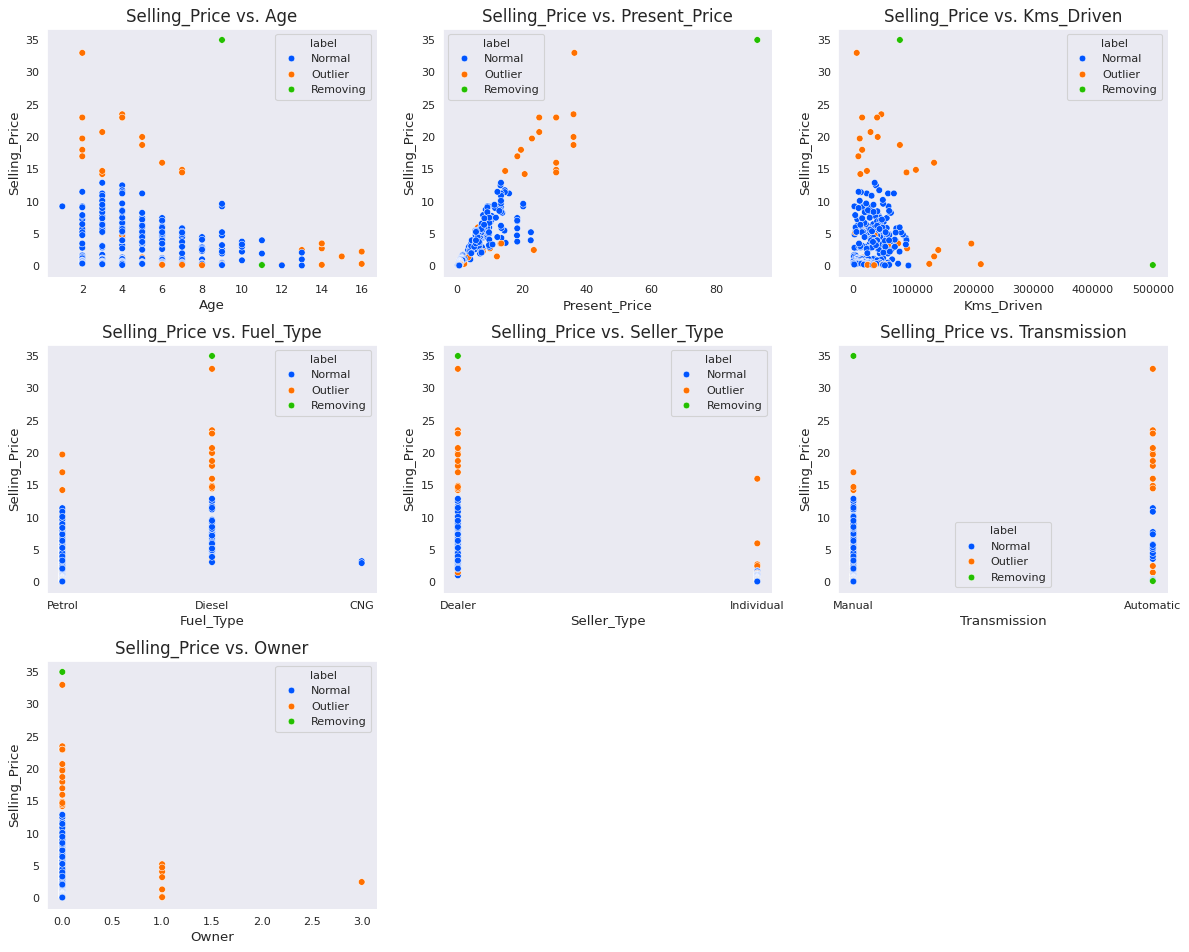

In [12]:
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'

# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1[target]>33].index)
removing_indexes.extend(df1[df1['Kms_Driven']>400000].index)
print(removing_indexes)
df1.loc[removing_indexes,'label'] = 'Removing'

#Plot
target = 'Selling_Price'
features = df.columns.drop(target)
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=80)

for i in range(len(features)):
    x=i//3
    y=i%3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x,y])
    ax[x,y].set_title('{} vs. {}'.format(target, features[i]), size = 15)
    ax[x,y].set_xlabel(features[i], size = 12)
    ax[x,y].set_ylabel(target, size = 12)
    ax[x,y].grid()

ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [13]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[196, 86]

In [14]:
df.isnull().sum()

,0
Age,0
Selling_Price,0
Present_Price,0
Kms_Driven,0
Fuel_Type,0
Seller_Type,0
Transmission,0
Owner,0


In [15]:
df[df.duplicated(keep=False)]  #Two cars can have same features and price so we are not dropping it.

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
15,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
17,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
51,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0
93,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0


In [16]:
#dropping outliers
df1 = df.copy()
df1.drop(removing_indexes, inplace = True)
df1.reset_index(drop = True, inplace = True)

# **Exploratory Data Analysis (EDA)**

In [17]:
#Univariate Analysis for categoryical variables
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

<ipython-input-18-60f093f9a2e2>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12)
<ipython-input-18-60f093f9a2e2>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12)
<ipython-input-18-60f093f9a2e2>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12)


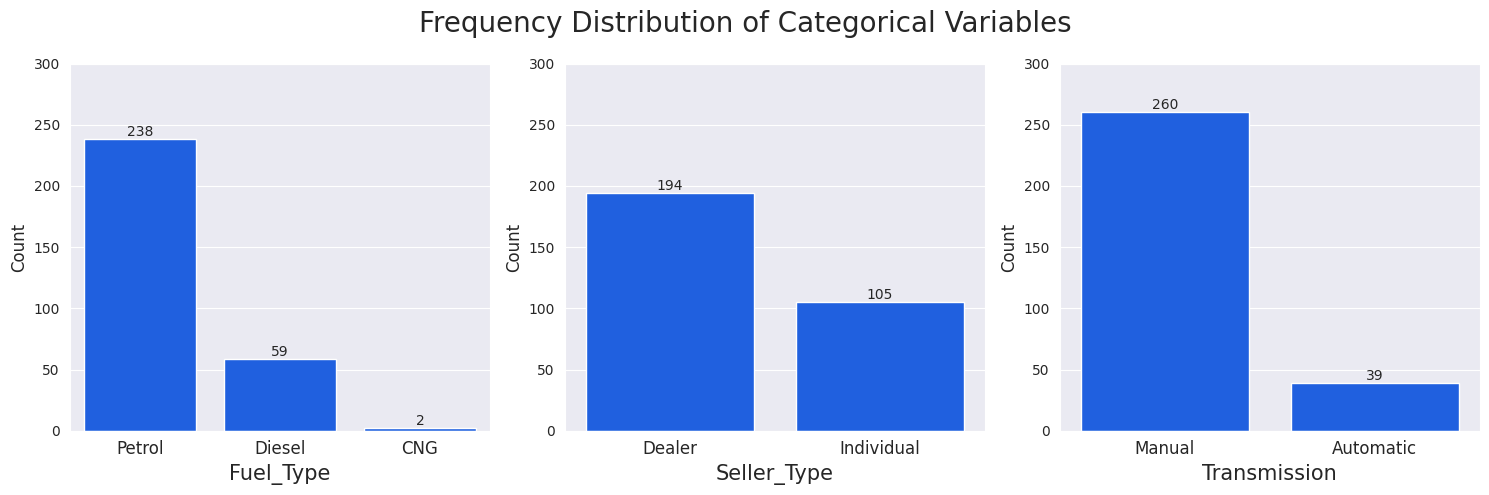

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), dpi=100)
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

for i in range(len(CatCols)):
    graph = sns.countplot(x=CatCols[i], data=df1, ax=ax[i])
    ax[i].set_xlabel(CatCols[i], fontsize=15)
    ax[i].set_ylabel('Count', fontsize=12)
    ax[i].set_ylim([0,300])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12)
    for cont in graph.containers:
        graph.bar_label(cont)

plt.suptitle('Frequency Distribution of Categorical Variables', fontsize=20)
plt.tight_layout()
plt.show()

In [19]:
#univariate analysis on numerical data
NumCols = ['Age', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']

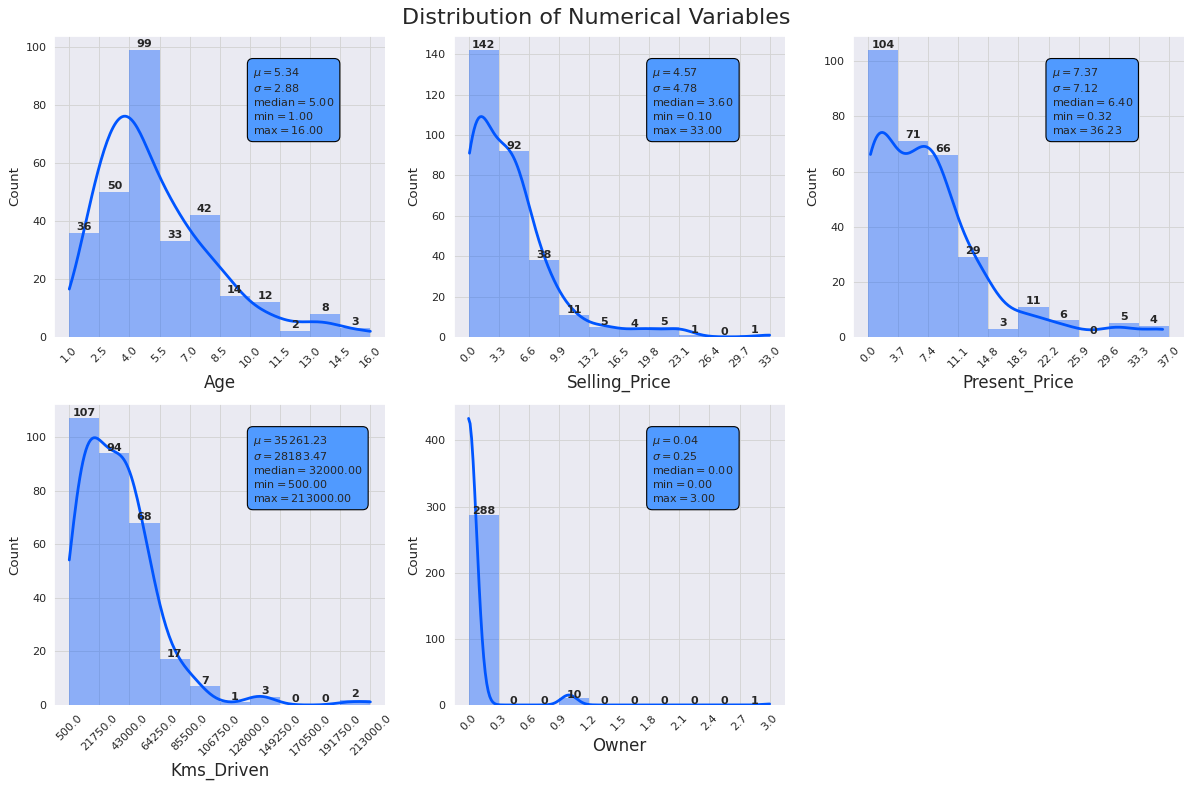

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi=80)
c = '#0055ff'

for i in range(len(NumCols)):
    row, col = divmod(i,3)
    values, bin_edges = np.histogram(df1[NumCols[i]],
                                     range=(np.floor(df1[NumCols[i]].min()), np.ceil(df1[NumCols[i]].max())))
    graph = sns.histplot(data=df1, x=NumCols[i], bins=bin_edges, kde=True, ax=ax[row,col],
                         edgecolor='none', color=c, alpha=0.4, line_kws={'lw': 2.5})
    ax[row,col].set_xlabel(NumCols[i], fontsize=15)
    ax[row,col].set_ylabel('Count', fontsize=12)
    ax[row,col].set_xticks(np.round(bin_edges,1))
    ax[row,col].set_xticklabels(ax[row,col].get_xticks(), rotation = 45)
    ax[row,col].grid(color='lightgrey')
    for j,p in enumerate(graph.patches):
        ax[row,col].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")
    textstr = '\n'.join((
    r'$\mu=%.2f$' %df1[NumCols[i]].mean(),
    r'$\sigma=%.2f$' %df1[NumCols[i]].std(),
    r'$\mathrm{median}=%.2f$' %np.median(df1[NumCols[i]]),
    r'$\mathrm{min}=%.2f$' %df1[NumCols[i]].min(),
    r'$\mathrm{max}=%.2f$' %df1[NumCols[i]].max()
    ))
    ax[row,col].text(0.6, 0.9, textstr, transform=ax[row,col].transAxes, fontsize=10, verticalalignment='top',
                     bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))

ax[1, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20)
plt.tight_layout()
plt.show()